In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5
fig_height = 4
fig_format = :png
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/run/media/alf/datos/misrepositorios/docencia/analisis-practicas-julia"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using SymPy  # Para el cálculo simbólico de integrales.
using QuadGK  # Para el cálculo numérico de integrales.
using Plots  # Para el dibujo de gráficas.
#plotlyjs()  # Para obtener gráficos interactivos.
using LaTeXStrings  # Para usar código LaTeX en los gráficos.
using PrettyTables # Para formatear tablas.

In [3]:
f(x) = x^2
Δx = 1/10
areas_inf = [f((i-1)*Δx)*Δx for i = 1:10]
sum_inf = sum(areas_inf)

0.2850000000000001

In [4]:
f(x) = x^2
Δx = 1/10
areas_sup = [f(i*Δx)*Δx for i = 1:10]
sum_sup = sum(areas_sup)

0.3850000000000001

In [5]:
error = sum_sup - sum_inf

0.10000000000000003

In [6]:
using PrettyTables
f(x) = x^2
function area_inf(a, b, n)
    Δx = (b-a)/n
    return sum([f(a+(i-1)*Δx)*Δx for i = 1:n])
end

function area_sup(a, b, n)
    Δx = (b-a)/n
    return sum([f(a+i*Δx)*Δx for i = 1:n])
end

function area(a, b, n)
    area = (area_inf(a, b, n) + area_sup(a, b, n)) / 2
    error = area_sup(a, b, n) - area_inf(a, b, n)
    return area, error
end

areas = [area(0, 1, n) for n=10:100]
pretty_table(hcat(first.(areas), last.(areas)); header = ["Aproximación", "Error"])

┌──────────────┬───────────┐
│ Aproximación │     Error │
├──────────────┼───────────┤
│        0.335 │       0.1 │
│     0.334711 │ 0.0909091 │
│     0.334491 │ 0.0833333 │
│      0.33432 │ 0.0769231 │
│     0.334184 │ 0.0714286 │
│     0.334074 │ 0.0666667 │
│     0.333984 │    0.0625 │
│      0.33391 │ 0.0588235 │
│     0.333848 │ 0.0555556 │
│     0.333795 │ 0.0526316 │
│      0.33375 │      0.05 │
│     0.333711 │  0.047619 │
│     0.333678 │ 0.0454545 │
│     0.333648 │ 0.0434783 │
│     0.333623 │ 0.0416667 │
│       0.3336 │      0.04 │
│      0.33358 │ 0.0384615 │
│     0.333562 │  0.037037 │
│     0.333546 │ 0.0357143 │
│     0.333532 │ 0.0344828 │
│     0.333519 │ 0.0333333 │
│     0.333507 │ 0.0322581 │
│     0.333496 │   0.03125 │
│     0.333486 │  0.030303 │
│     0.333478 │ 0.0294118 │
│     0.333469 │ 0.0285714 │
│     0.333462 │ 0.0277778 │
│     0.333455 │  0.027027 │
│     0.333449 │ 0.0263158 │
│     0.333443 │  0.025641 │
│     0.333438 │     0.025 │
│     0.333432

In [7]:
using SymPy
@vars x real=true
primitiva = integrate(x^2*ln(x))

 3           3
x ⋅log(x)   x 
───────── - ──
    3       9 

In [8]:
diff(primitiva)

 2       
x ⋅log(x)

In [9]:
integrate(ln(ln(x))/x)

log(x)⋅log(log(x)) - log(x)

In [10]:
h(x) = (2x^3+x^2+6)/(x^5-x)
# Descomposición en fracciones simples.
apart(h(x))

 5⋅x + 2         5           9       6
────────── + ───────── + ───────── - ─
  ⎛ 2    ⎞   4⋅(x + 1)   4⋅(x - 1)   x
2⋅⎝x  + 1⎠                            

In [11]:
integrate(h(x))

                                               ⎛ 2    ⎞          
            9⋅log(x - 1)   5⋅log(x + 1)   5⋅log⎝x  + 1⎠          
-6⋅log(x) + ──────────── + ──────────── + ───────────── + atan(x)
                 4              4               4                

In [12]:
@vars a real=true
integrate(x^a, x)

⎧ a + 1            
⎪x                 
⎪──────  for a ≠ -1
⎨a + 1             
⎪                  
⎪log(x)  otherwise 
⎩                  

In [13]:
@vars x real=true
j(x) = (1 + log(x)) * sqrt(1 + (x*log(x))^2 )
# El cálculo directo de la integral no funciona.
integrate(j(x))
# Ayudamos a SymPy con la sustitución.
u(x) = x*log(x)
@vars y dy real=true
# Definimos la nueva función con el cambio de variable.
g(y) = j(x)(u(x) => y, diff(u(x), x) => 1)
# Integramos la nueva función y deshacemos el cambio de variable.
integrate(g(y))(y => u(x))

     ________________                         
    ╱  2    2                                 
x⋅╲╱  x ⋅log (x) + 1 ⋅log(x)   asinh(x⋅log(x))
──────────────────────────── + ───────────────
             2                        2       

In [14]:
using SymPy
@vars x real=true
integrate(x^3/x^2+x+1, -1/2, 0)

0.250000000000000

In [15]:
integrate(sqrt(16-x^2)/x, 2, 4)

-2⋅√3 + 4⋅acosh(2)

In [16]:
integrate(1/(3+cos(2x)), 0, PI/2)

√2⋅π
────
 8  

In [17]:
using SymPy
@vars x real=true
f(x) = x^x
integrate(f(x), 0, 1)

1      
⌠      
⎮  x   
⎮ x  dx
⌡      
0      

In [18]:
using QuadGK
quadgk(f(x), 0, 1, rtol = 10^-10)

(0.783430510710741, 7.598588099878845e-11)

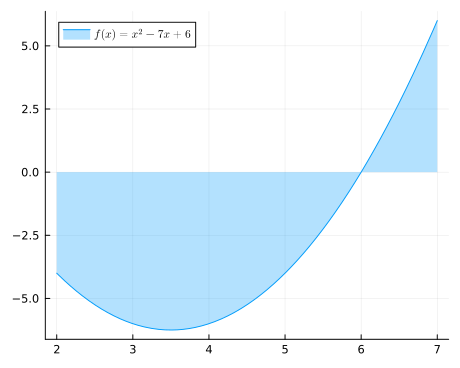

In [19]:
using Plots, SymPy, LaTeXStrings
@vars x real = true
f(x) = x^2-7x+6
plot(f, 2, 7, fillrange = 0, fillalpha = 0.3, label = L"$f(x)=x^2-7x+6$")

In [20]:
# Calculamos primero las raíces de la función
solve(f(x))
# Descomponemos el intervalo de integración en los subintervalos [2,6] (función negativa) y [6,7] (función positiva) y calculamos las integrales por separado
-integrate(f, 2, 6) + integrate(f, 6, 7)

43/2

In [21]:
integrate(abs(f(x)), 2, 7)

43/2

In [22]:
using Plots, SymPy, LaTeXStrings
@vars x real = true
f(x) = -x^2+6x
g(x) = x^2-2x
# Calculamos primero los puntos de corte de la función.
raices = solve(f(x)-g(x))
# Descomponemos el intervalo de integración en los subintervalos [2,6] (función negativa) y [6,7] (función positiva) y calculamos las integrales por separado
sol = integrate(f(x)-g(x), raices[1], raices[2])

64/3

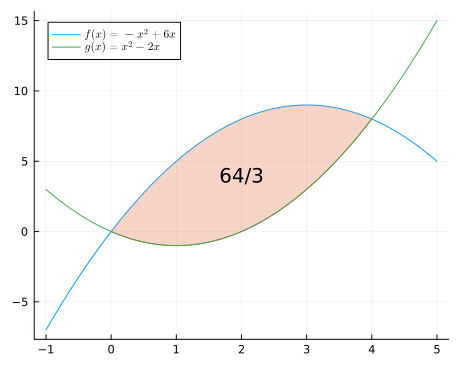

In [23]:
using Plots, SymPy, LaTeXStrings
@vars x real = true
f(x) = -x^2+6x
g(x) = x^2-2x
plot(f, -1, 5, label = L"$f(x)=-x^2+6x$")
plot!(g, 0, 4, fillrange = f, fillalpha = 0.3, label = "")
plot!(g, label = L"$g(x)=x^2-2x$")
annotate!(2, 4, sol)

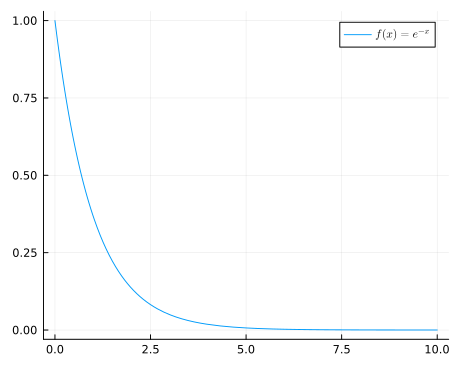

In [24]:
using Plots, SymPy, LaTeXStrings
@vars x real = true
f(x) = exp(-x)
plot(f(x), 0, 10, label = L"$f(x)=e^{-x}$")

In [25]:
integrate(f(x), 0, oo)

1

In [26]:
using SymPy
@vars x real = true
f(x) = sin(x)^2
1/(2*PI) * integrate(f(x), 0, 2PI)

1/2

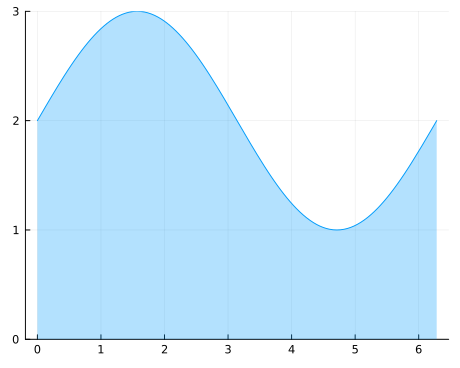

In [27]:
using SymPy, Plots
@vars x real = true
f(x) = sin(x)+2
plot(f, 0, 2pi, ylim=(0,3), fillrange = 0, fillalpha = 0.3, label = "")

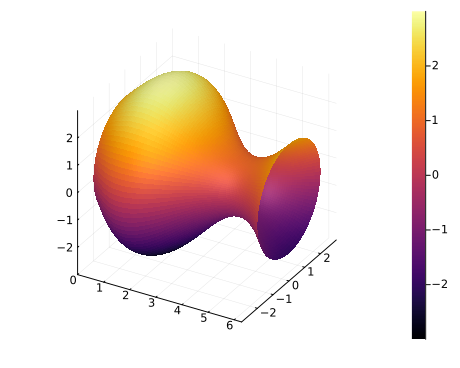

In [28]:
using Unzip
@vars x, u, v real=true
f(x) = sin(x)+2
S(u, v) = (u, f(u)*cos(v), f(u)*sin(v))
us = range(0, 2pi, length=100)
vs = range(0, 2pi, length=100)
ws = unzip(S.(us, vs'))
surface(ws...)

WebIO._IJuliaInit()

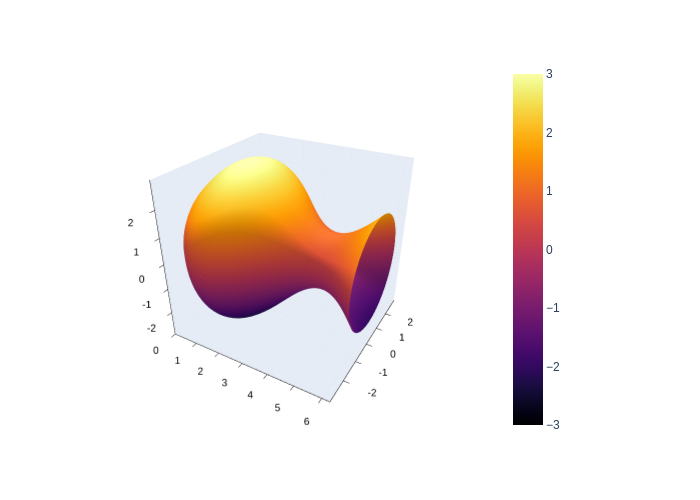

In [29]:
# Activamos el bakden de Plotly.
plotlyjs()
@vars x, u, v real=true
f(x) = sin(x)+2
S(u, v) = (u, f(u)*cos(v), f(u)*sin(v))
us = range(0, 2pi, length=100)
vs = range(0, 2pi, length=100)
ws = unzip(S.(us, vs'))
plot(surface(ws...))

In [30]:
N(integrate(pi*f(x)^2, 0, 2pi))

88.82643960980422410690317029966353336734417982417697812151367494195434357891355

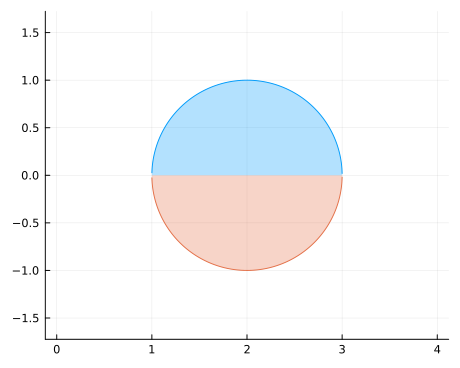

In [31]:
using SymPy, Plots
# Volvemos a activar el backend por defecto.
gr()
@vars x real = true
f(x) = sqrt(1-(x-2)^2)
plot(f(x), 0, 4, fillrange = 0, fillalpha = 0.3, aspect_ratio = 1, label = "")
plot!(-f(x), 0, 4, fillrange = 0, fillalpha = 0.3, aspect_ratio = 1, label = "")

In [32]:
2 * integrate(2PI*x*f(x), 1, 3)

   2
4⋅π 

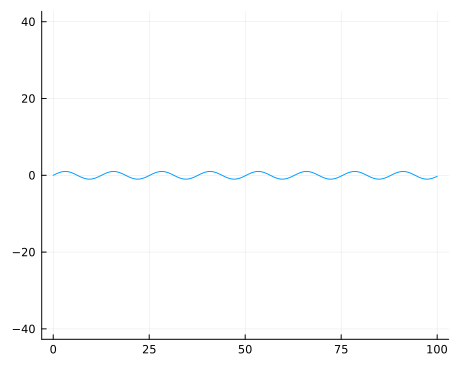

In [33]:
using SymPy, Plots
@vars x real = true
f(x) = sin(x/2)
plot(f(x), 0, 100, aspect_ratio = 1, label = "")

In [34]:
using QuadGK
quadgk(sqrt(1+diff(f(x))^2), 0, 100)

(105.954416730336, 1.2200227161862642e-6)

In [35]:
using SymPy
@vars x real = true
f(x) = 1/x
integrate(PI*f(x)^2, 1, oo)

π

In [36]:
using SymPy
@vars x real = true
f(x) = 1/x
integrate(2PI*f(x)*sqrt(1+diff(f(x))^2), 1, oo)

∞

In [37]:
using SymPy
@vars x y real=true
f(x) = x^2/2
f⁻¹(y) = solve(y-f(x), x)[2]
# Volumen hasta una altura h
V(x) = integrate(PI*f⁻¹(y)^2, 0, x)
# Nivel para un volumen de 100 m³
nivel = solve(V(x)-100)[2]

10
──
√π

In [38]:
δ = 900
gravedad = 9.81
N(integrate(gravedad*δ*PI*f⁻¹(y)^2*(4-y), 0, nivel))

210780.1112379064950236043481132925597219179957695127286157114420111584307533701

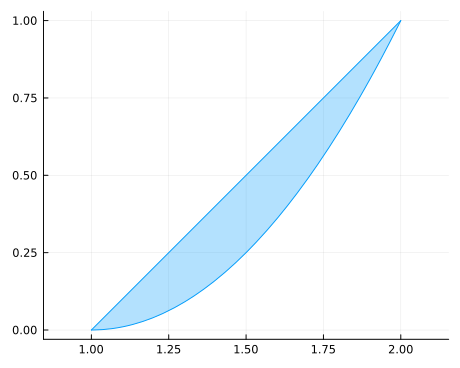

In [39]:
using SymPy, Plots
@vars x real = true
f(x) = x-1
g(x) = (x-1)^2
# Calculo de los puntos de corte.
a, b = N(solve(f(x)-g(x)))
plot(f(x), a, b, aspect_ratio = 1, label = "")
plot!(g(x), a, b, fillrange = f, fillalpha = 0.3, aspect_ratio = 1, c = 1, label = "")

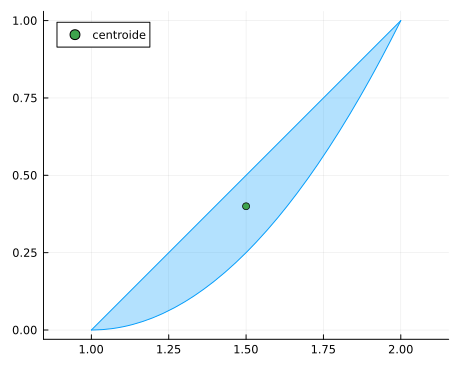

In [40]:
# Coordenada x del centroide.
cx = integrate(x*(f(x)-g(x)), a, b) / integrate(f(x)-g(x), a, b)
# Coordenada y del centroide
cy = 1/2 * integrate(f(x)^2-g(x)^2, a, b) / integrate(f(x)-g(x), a, b)
# Dibujamos el centroide
scatter!((cx,cy), label = "centroide")

In [41]:
2*PI*cy*integrate(f(x)-g(x), a, b)

0.133333333333333⋅π

In [42]:
2*PI*cx*integrate(f(x)-g(x), a, b)

π
─
2

In [43]:
#| echo: false
using QuizQuestions, SymPy
nothing

In [44]:
#| echo: false
f(x) = sqrt(log(x))
Δx = 1/100
areas_sup = [f(1+i*Δx)*Δx for i = 1:100]
sol = sum(areas_sup)
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(0.5965478754886948, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [45]:
#| echo: false
@vars x real = true
f(x) = sin(x)
g(x) = cos(x)
sol = N(integrate(abs(f(x)-g(x)), 0, pi))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(2.828427124746189986581074985903742114776176941671864896353359475981464956924204, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [46]:
#| echo: false
using QuadGK
@vars x real = true
f(x) = exp(-1/2 * x^2)/sqrt(2*pi)
sol = N(integrate(f(x), -oo, oo))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(0.999999999999999986409302776619059759057679898798192459517020044702050192775919, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [47]:
#| echo: false
@vars t real = true
T(t) = 100t*exp(-t)
sol = N(1/5 * integrate(T(t), 1, 5))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(13.90662400696743681222462499568062378797049503798810312867680827917643712792353, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [48]:
#| echo: false
@vars x real = true
f(x) = log(x)
g(x) = (x-1)/2
a, b = solve(f(x)-g(x))
sol = N(integrate(PI*(f(x)-g(x))^2, a, b))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(0.156113554147635423512880988563804544803263258396001313379540434648561645472583, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [49]:
#| echo: false
sol = N(integrate(2PI*x*(f(x)-g(x)), a, b))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(4.360963102597601223533683953698120937110290425108162641159290257022389485589617, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [50]:
#| echo: false
@vars x real = true
c(x) = 2cosh(x/2)
sol = quadgk(sqrt(1+diff(c)^2), -1, 1)
numericq(sol[1], 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(2.08438122197499, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [51]:
#| echo: false
using SymPy, QuadGK
@vars x real = true
f(x) = sqrt(1-x^2/4)
sol = quadgk(2PI*f(x)*sqrt(1+diff(f(x))^2), -2, 2)
numericq(N(sol[1]), 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(21.47843532788372738515464173066449587194764213998598093442381859591430985920106, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [52]:
#| echo: false
choices = ("La media es mayor que la mediana.", "La media es igual que la mediana", "La media es menor que la mediana")
answer = 3
radioq(choices, answer)

QuizQuestions.Radioq(("La media es menor que la mediana", "La media es mayor que la mediana.", "La media es igual que la mediana"), 1, [1, 2, 3], ("La media es menor que la mediana", "La media es mayor que la mediana.", "La media es igual que la mediana"), "", "", "", false)